# Creating a custom callback

https://github.com/stephenjohnmoore/Coursera-Deep-Learning/blob/master/Custom%20Models%2C%20Layers%2C%20and%20Loss%20Functions%20with%20TensorFlow/Week%205%20-%20Bonus%20Content%20-%20Callbacks/C1_W5_Lab_2_custom-callbacks.ipynb

https://www.coursera.org/learn/custom-models-layers-loss-functions-with-tensorflow/lecture/1NR1C/custom-callbacks


https://www.coursera.org/learn/custom-models-layers-loss-functions-with-tensorflow/lecture/EEWio/custom-callbacks-code-walkthrough

In [105]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import datetime
import io

from PIL import Image
from IPython.display import Image as IPyImage
import imageio

from tensorflow.keras.callbacks import TensorBoard
%load_ext tensorboard

print("Version: ", tf.__version__)
tf.get_logger().setLevel('INFO')

## use cpu only
# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

Version:  2.6.0


In [117]:
# Define the Keras model to add callbacks to
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation = 'relu', input_dim = 784))
    model.add(tf.keras.layers.Dense(10, activation = 'softmax'))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.1), loss='sparse_categorical_crossentropy', metrics=['mae'])
    return model

In [26]:
# Load example MNIST data and pre-process it
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


In [27]:
x_train.shape

(60000, 28, 28)

In [ ]:
im = x_train[1][:]
im2 = x_train[2][:]
im = im.reshape(28,28)
im2 = im2.reshape(28,28)

# im.reshape(38
print(im.shape)
plt.figure(facecolor='w')
# plt.imshow(im )
plt.title("0", color='red')

_, axs = plt.subplots(1, 2, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip([im, im2], axs):
    ax.imshow(img)
# plt.show()

In [28]:
# 28 x 28 = 784 we're effectively flattening it when we reshape like that
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

In [9]:
class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_train_batch_begin(self, batch, logs=None):
        print("Training: batch {} begins at {}".format(batch, datetime.datetime.now().time()))
    
    def on_train_batch_end(self, batch, logs=None):
        print('Training: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))

In [15]:
model = get_model()
history = model.fit(x_train, y_train, batch_size = 64, epochs=1, steps_per_epoch=5, verbose=0,
                    callbacks=[MyCustomCallback()])

/home/mo/.local/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Training: batch 0 begins at 17:55:56.159001
Training: batch 0 ends at 17:55:56.337825
Training: batch 1 begins at 17:55:56.337965
Training: batch 1 ends at 17:55:56.339161
Training: batch 2 begins at 17:55:56.339238
Training: batch 2 ends at 17:55:56.340172
Training: batch 3 begins at 17:55:56.340247
Training: batch 3 ends at 17:55:56.341044
Training: batch 4 begins at 17:55:56.341118
Training: batch 4 ends at 17:55:56.341973


In [102]:
class VisCallback(tf.keras.callbacks.Callback):
    def __init__(self, inputs, ground_truth, display_freq=10, n_samples=10):
        self.inputs = inputs
        self.ground_truth=ground_truth # the true label
        self.images = []
        self.display_freq = display_freq # freq in epchs
        self.n_samples = n_samples #num of mnist images to use for the visualization
        
    def on_epoch_end(self, epoch, logs=None):
        #randomly sample data
        indexes = np.random.choice(len(self.inputs), size=self.n_samples) # list of random idx
        x_test, y_test = self.inputs[indexes], self.ground_truth[indexes]
        prediction = np.argmax(self.model.predict(x_test), axis=1)
        
        self.display_digits(x_test, prediction, y_test, epoch, n=self.display_freq)
        # save figure
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        image = Image.open(buf)
        self.images.append(np.array(image))
        
#         display the images every remainder of the freq
        if epoch % self.display_freq == 0:
            plt.show()
            
    def on_train_end(self, logs=None):
        imageio.mimsave('animation.gif', self.images, fps=1)
        
    def display_digits(self, images_to_predict, predictions, true_labels, epoch, n):
        # the images are flattened so I have to put them to 28x28
        # right now the shape is (num_imgs, 784) I want (num_imgs, 28, 28)
        num_imgs = len(images_to_predict)
        images_to_predict = images_to_predict.reshape(num_imgs, 28,28)

        f, axs = plt.subplots(1, num_imgs, figsize=(12, 12))
        f.set_facecolor('w')
        axs = axs.flatten()
        for i in range(num_imgs):
            ax = axs[i]
            img = images_to_predict[i]
            predicted = predictions[i]
            actual_label = true_labels[i]

            if predicted == actual_label:
                ax.set_title(f"right {str(predicted)}", color= 'green')
            else:
                ax.set_title(f"wrong, {str(predicted)}", color = 'red')

                
            ax.imshow(img)
            ax.axis('off')
   

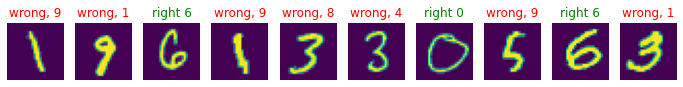

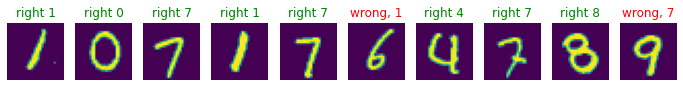

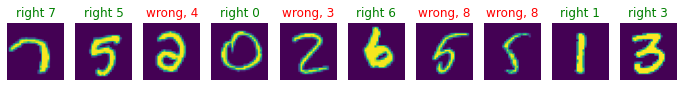

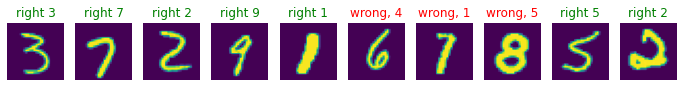

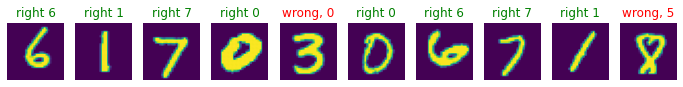

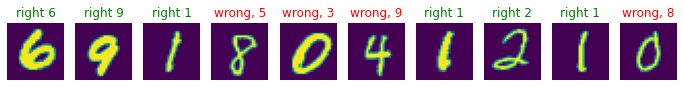

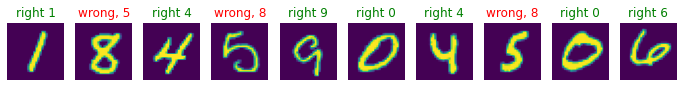

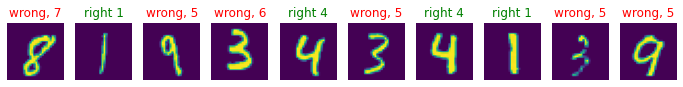

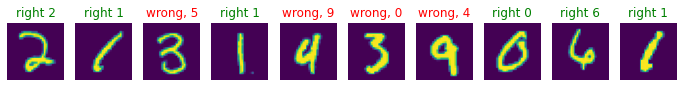

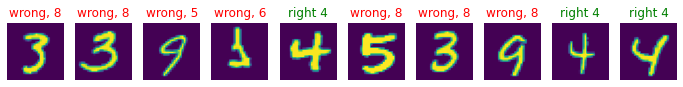

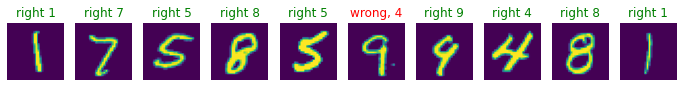

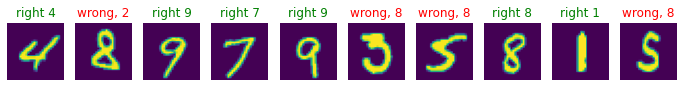

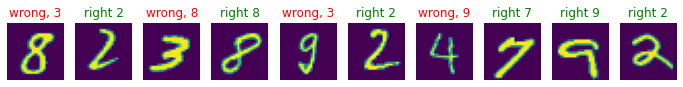

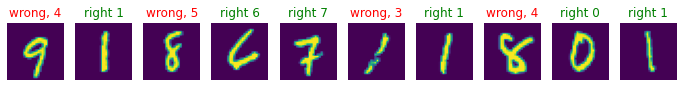

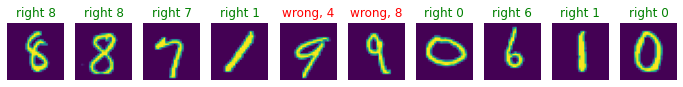

In [118]:
model = get_model()

history = model.fit(x_train, y_train, batch_size = 64, epochs=15, steps_per_epoch=5, verbose=0,
                    callbacks=[VisCallback(x_test, y_test),  TensorBoard(log_dir='./log_dir')])

In [121]:
%tensorboard --logdir log_dir

Reusing TensorBoard on port 6007 (pid 8947), started 12:16:49 ago. (Use '!kill 8947' to kill it.)

In [120]:
model.evaluate(x_test, y_test, return_dict=True)

313/313 [==============================] - 0s 643us/step - loss: 0.9574 - mae: 4.3630


{'loss': 0.9574279189109802, 'mae': 4.3629984855651855}